<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Multi-spectral-dataset-(11-years)" data-toc-modified-id="Multi-spectral-dataset-(11-years)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Multi-spectral dataset (11 years)</a></span><ul class="toc-item"><li><span><a href="#Un-filtered-data" data-toc-modified-id="Un-filtered-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Un-filtered data</a></span></li><li><span><a href="#Filtered-data" data-toc-modified-id="Filtered-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Filtered data</a></span></li><li><span><a href="#Feature-selection-with-the-Lasso" data-toc-modified-id="Feature-selection-with-the-Lasso-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Feature selection with the Lasso</a></span></li></ul></li><li><span><a href="#Climatic-dataset-(3-years)" data-toc-modified-id="Climatic-dataset-(3-years)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Climatic dataset (3 years)</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#3-hourly" data-toc-modified-id="3-hourly-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>3-hourly</a></span></li><li><span><a href="#daily-averages" data-toc-modified-id="daily-averages-2.0.2"><span class="toc-item-num">2.0.2&nbsp;&nbsp;</span>daily averages</a></span></li></ul></li></ul></li><li><span><a href="#Crop-yield-prediction" data-toc-modified-id="Crop-yield-prediction-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Crop yield prediction</a></span><ul class="toc-item"><li><span><a href="#RBF-RBF" data-toc-modified-id="RBF-RBF-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>RBF-RBF</a></span></li><li><span><a href="#kerES" data-toc-modified-id="kerES-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>kerES</a></span></li><li><span><a href="#linSES" data-toc-modified-id="linSES-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>linSES</a></span></li></ul></li></ul></div>

In [3]:
!pip install esig
!pip install iisignature

In [2]:
import sys
sys.path.append('../src')
import warnings
warnings.filterwarnings('ignore')

import pickle
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
from tqdm import tqdm
import pandas as pd

import utils_crops
import esig.tosig as esig

import RBF_RBF
import RBF_TKA
import RBF_Matern
import kerES
import KES
import linSES
import sklearn_transformers
import deep_sets

import sklearn_transformers
import iisignature
from sklearn.linear_model import LassoCV

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (5, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

ModuleNotFoundError: No module named 'iisignature'

# Multi-spectral dataset (11 years)

In [23]:
targets_dico = pickle.load(open('../data/labels_ndvi_dico.obj', 'rb')) # dictionary containing the yields
y = list(targets_dico.values()) # yield targets

## Un-filtered data

In [24]:
X = pickle.load(open('../data/bags_ndvi.obj','rb'))

## Filtered data


In [20]:
# X, target_dico_filter = utils_crops.filter_ndvi_data(X,targets_dico)
# y = list(target_dico_filter.values())

## Feature selection with the Lasso

In [25]:
# to possibly augment the state space of the time-series
ll = None
at = False

# signature truncation levels 
depth1 = 2
depth2 = 2
 
# possibly augment the state space of the time-series
if ll is not None:
    X = sklearn_transformers.LeadLag(ll).fit_transform(X)
if at:
    X = sklearn_transformers.AddTime().fit_transform(X)

pwES =  sklearn_transformers.pathwiseExpectedSignatureTransform(order=depth1).fit_transform(X)
SpwES = sklearn_transformers.SignatureTransform(order=depth2).fit_transform(pwES)


In [26]:
clf = LassoCV(cv=20, normalize=True).fit(SpwES, y)
importance = np.abs(clf.coef_)

In [27]:
dico = {1:'nR',2:'R'}
dico = utils_crops.get_sig_keys(utils_crops.get_sig_keys(dico,2),2)
interpretability = {sig_term:val for sig_term,val in zip(dico.values(),importance)}

In [30]:
df = pd.DataFrame.from_dict(interpretability, orient='index').sort_values(0, ascending=True).iloc[25:,:]
df.columns = ['feature importance']

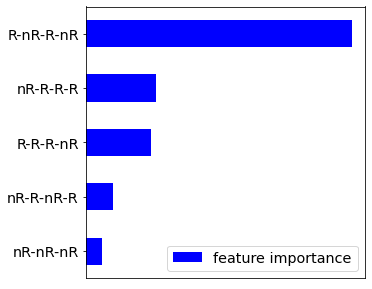

In [31]:
fig, ax = plt.subplots()
df.plot(kind='barh', color='blue', ax=ax, grid=False)
ax.legend(loc='lower right')
# ax.set_xlabel('amplitude')
plt.xticks([])
#plt.savefig('../pictures/feature_importance.png')
plt.show()

# Climatic dataset (3 years)

In [2]:
targets_dico = pickle.load(open('../data/clim_labels.obj', 'rb'))
y = list(targets_dico.values())

### 3-hourly 

In [3]:
reload(utils_crops)
input1 = pickle.load(open('../data/clim_bags_1.obj', 'rb'))
input2 = pickle.load(open('../data/clim_bags_2.obj', 'rb'))
X = input1 + input2

In [4]:
X = [[item[::2,:] for item in bag] for bag in X]

In [5]:
# possibly subsample the data
subsamping_rate = 0.5 # fraction of observations to drop
X = utils_crops.subsample(input_=X,p=subsamping_rate,N_items=30,time=False)

###  daily averages

In [8]:
# X = pickle.load(open('crops/clim_summary_bags.obj', 'rb'))

# Crop yield prediction

## RBF-RBF

In [8]:
m_mse,std_rmse,results_RBF = RBF_RBF.model(X=X, y=y, ll=None, at=False, mode='krr', NUM_TRIALS=5,  cv=3)

100%|██████████| 5/5 [02:19<00:00, 27.93s/it]


In [10]:
print(mse(results_RBF))
print(mape(results_RBF))

(0.8774499662495663, 0.30604904139551115)
(14.04241359181151, 2.8408122818619113)


## RBF-Matern

In [13]:
m_mse,std_rmse,results_Matern = RBF_Matern.model(X=X, y=y, ll=None, at=False, mode='krr', NUM_TRIALS=5,  cv=3)

100%|██████████| 5/5 [02:20<00:00, 28.15s/it]


In [14]:
print(mse(results_Matern))
print(mape(results_Matern))

(0.8506657673057927, 0.27845203439396343)
(13.855261821389712, 2.805139519239346)


## RBF-GA

In [15]:
m_mse,std_rmse,results_GA = RBF_TKA.model(X=X, y=y, ll=None, at=False, lambdas=[0.001], mode='krr', NUM_TRIALS=5,  cv=3)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   56.6s
[Parallel(n_jobs=-1)]: Done 544 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1312 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 2211 out of 2211 | elapsed:  6.0min finished


best sigma (cv on the train set):  0.001
best sigma (cv on the train set):  0.001
best sigma (cv on the train set):  0.001
best sigma (cv on the train set):  0.001
best sigma (cv on the train set):  0.001


In [16]:
print(mse(results_GA))
print(mape(results_GA))

(0.6963953478866836, 0.2012842334564594)
(12.335624703304738, 2.000392799121177)


## KES

In [17]:
reload(KES)
m_mse,std_rmse,results_KES = KES.model(X, y,ll=None, at=False, scales=[0.06],mode='krr', NUM_TRIALS=5,  cv=3)

  0%|          | 0/1 [00:00<?, ?it/s]

(424, 3)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 128 concurrent workers.
  0%|          | 0/1 [00:07<?, ?it/s]


KeyboardInterrupt: 

In [24]:
print(mse(results_KES)) 
print(mape(results_KES))

(0.7711400625203998, 0.08727561057347544)
(13.658909741028978, 1.6363235790594541)


## linSES

In [219]:
print(len(X[0][0]))

254


In [28]:
reload(linSES)
reload(sklearn_transformers)
m_mse,std_rmse,results_SES = linSES.model(X, y, depths1=[2,3], depth2=1, ll=[0,1], at=True, NUM_TRIALS=5,  cv=3)


 20%|██        | 1/5 [00:06<00:25,  6.50s/it]

best truncation level (cv on train set):  3


 40%|████      | 2/5 [00:10<00:17,  5.84s/it]

best truncation level (cv on train set):  3


 60%|██████    | 3/5 [00:14<00:10,  5.34s/it]

best truncation level (cv on train set):  3


 80%|████████  | 4/5 [00:19<00:04,  4.98s/it]

best truncation level (cv on train set):  3


100%|██████████| 5/5 [00:23<00:00,  4.66s/it]

best truncation level (cv on train set):  3


In [29]:
print(mse(results_SES)) # 30 %
print(mape(results_SES))

(0.6911982409537598, 0.17720411296647087)
(11.507106569871326, 2.6926418654168773)


In [9]:
def mse(results):
    mse_vec = np.zeros(len(results))
 
    for i in range(len(results)):
        pred = results[i]['pred']
        true = results[i]['true']
        mse_vec[i]=np.mean((pred-true)**2)
    return np.mean(mse_vec), np.std(mse_vec)

def mape(results):
    mape_vec = np.zeros(len(results))
 
    for i in range(len(results)):
        pred = results[i]['pred']
        true = results[i]['true']
        mape_vec[i]=np.mean(np.abs((true - pred) / true))*100 
    return np.mean(mape_vec), np.std(mape_vec)

In [18]:
reload(deep_sets)
from sklearn.model_selection import train_test_split
import torch
batch_size = 50
nb_epoch = 500
reload(deep_sets)
data = X.copy() 
ll= None
at = False
from sklearn_transformers import AddTime, LeadLag
if ll is not None:
    data = LeadLag(ll).fit_transform(data)
if at:
    data = AddTime().fit_transform(data)

initial test 37.269398484911235
Train loss: 38.394222
Train loss: 0.120012
Train loss: 0.008707
Train loss: 0.000455
Train loss: 0.000003
Train loss: 0.000000
Train loss: 0.000000
Train loss: 0.000000
Train loss: 0.000000
Train loss: 0.000000


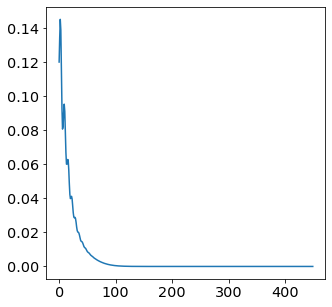

final test 1.7422959958868367
initial test 38.04781014578683
Train loss: 43.789677
Train loss: 0.016178
Train loss: 0.003582
Train loss: 0.000842
Train loss: 0.000127
Train loss: 0.000011
Train loss: 0.000001
Train loss: 0.000000
Train loss: 0.000000
Train loss: 0.000000


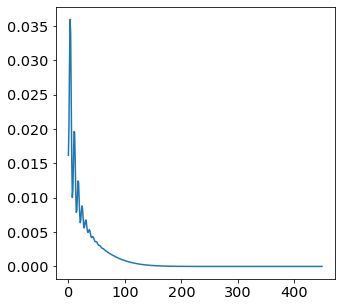

final test 2.344744556450418
initial test 40.733011381966726
Train loss: 40.139481
Train loss: 0.120969
Train loss: 0.004293
Train loss: 0.000026
Train loss: 0.000000
Train loss: 0.000000
Train loss: 0.000000
Train loss: 0.000000
Train loss: 0.000000
Train loss: 0.000000


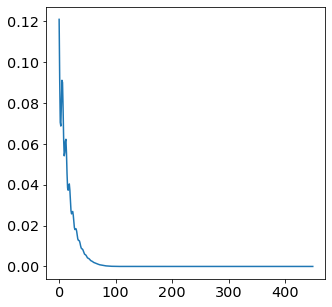

final test 3.172501739239254
initial test 36.99200282778059
Train loss: 36.829662
Train loss: 0.102796
Train loss: 0.003350
Train loss: 0.000481
Train loss: 0.000033
Train loss: 0.000001
Train loss: 0.000000
Train loss: 0.000000


In [ ]:
MSEs = []
results = [] 
import time 
start = time.time()
for j in range(5):
    
    X_train, X_test, y_train, y_test = train_test_split([[x.reshape(-1) for x in xx[:14]] for xx in data], y, test_size=0.2, random_state=j)

    train = deep_sets.DataIterator(torch.Tensor(X_train), torch.Tensor(y_train), len(X_train), shuffle=True)
    test  = deep_sets.DataIterator(torch.Tensor(X_test), torch.Tensor(y_test), 1)

    model = deep_sets.DeepSet
    
    t = deep_sets.Trainer(train.d, model, nb_epoch)
    res = t.evaluate(test)
    print('initial test', np.mean(res))
    t.fit(train,test)
    res = t.evaluate(test)
    MSEs.append(res)
    res_full = t.evaluate(test,return_all=True)
    results.append(res_full)
    print('final test', np.mean(res))
end = time.time()
print(end-start)
print(np.mean(MSEs), np.std(MSEs))

In [116]:
for i in range(len(results)):
    results[i]['pred']=np.array([e.cpu().numpy()[0][0] for e in results[i]['pred']])
    results[i]['true']=np.array([e.cpu().numpy()[0] for e in results[i]['true']])

print(mape(results))
print(mse(results))

(23.128157556056976, 8.262600714832166)
(2.4083415031433106, 1.2341692005475928)
